In [28]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os 
from tqdm import tqdm
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [29]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

/home/boron/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/boron/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

In [31]:
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = './imagenet_samples'

# List of image file paths
image_paths = os.listdir(imagenet_path)

print("ImagePaths: ", image_paths)

ImagePaths:  ['mountain_bike.JPEG', 'mousetrap.JPEG', 'paintbrush.JPEG', 'peacock.JPEG', 'piggy_bank.JPEG']


In [ ]:
# code modified from https://github.com/kazuto1011/smoothgrad-pytorch/blob/master/smooth_grad.py

In [38]:
def one_hot_gradient_class(idx, probs):
    one_hot = torch.FloatTensor(probs.size()[-1]).zero_()
    one_hot[idx] = 1
    return one_hot

def img_to_grayscale(img):
  img_2d = np.sum(img, axis=0)
  span = abs(np.percentile(img_2d, 99))
  vmin = -span
  vmax = span
  img_2d = np.clip((img_2d - vmin) / (vmax - vmin), -1, 1)
  return img_2d * 255

def generate_smoothgrad(image, target_class, model, sigma, n_samples):
  grads = []
  image = image.data
  sigma = (image.max() - image.min()) * sigma
  total_gradients = np.zeros_like(image)

  for sample in tqdm(range(n_samples)):
    noise = np.random.normal(0, sigma, image.size()).astype(np.float32)
    noised_image = image + torch.from_numpy(noise)
    noised_image = Variable(noised_image, requires_grad=True)
    predictions = model.forward(noised_image)
    if noised_image.grad is not None:
      noised_image.grad.data.zero_()
    one_hot = one_hot_gradient_class(target_class, predictions)
    one_hot = torch.sum(one_hot * predictions)
    one_hot.backward(retain_graph=True)

    total_gradients += noised_image.grad.data.cpu().numpy()

  avg_gradients = total_gradients[0, :, :, :] / n_samples
  noise_map = img_to_grayscale(avg_gradients)
  return noise_map, avg_gradients

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


Unperturbed Predicted label: n03792782 (mountain_bike)
Perturbed Predicted label: n03792782 (mountain_bike)


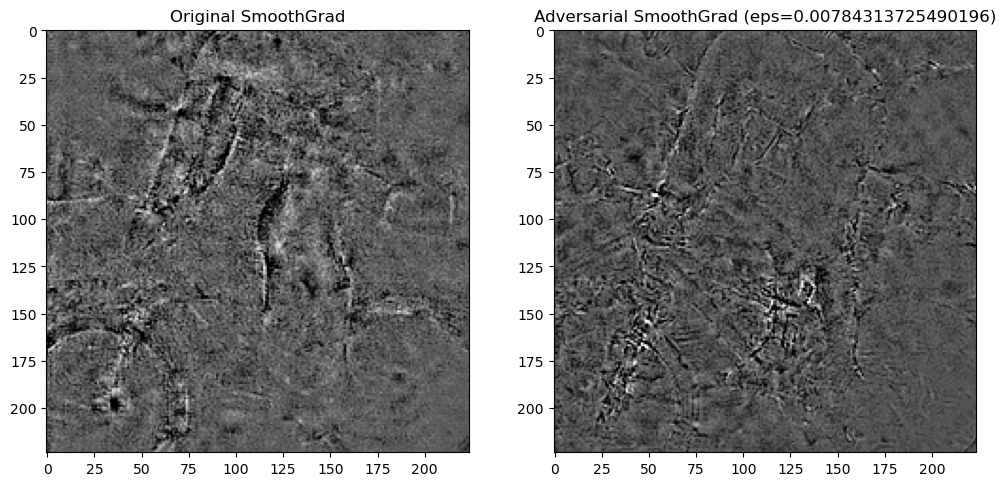

100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


Unperturbed Predicted label: n03792782 (mountain_bike)
Perturbed Predicted label: n03792782 (mountain_bike)


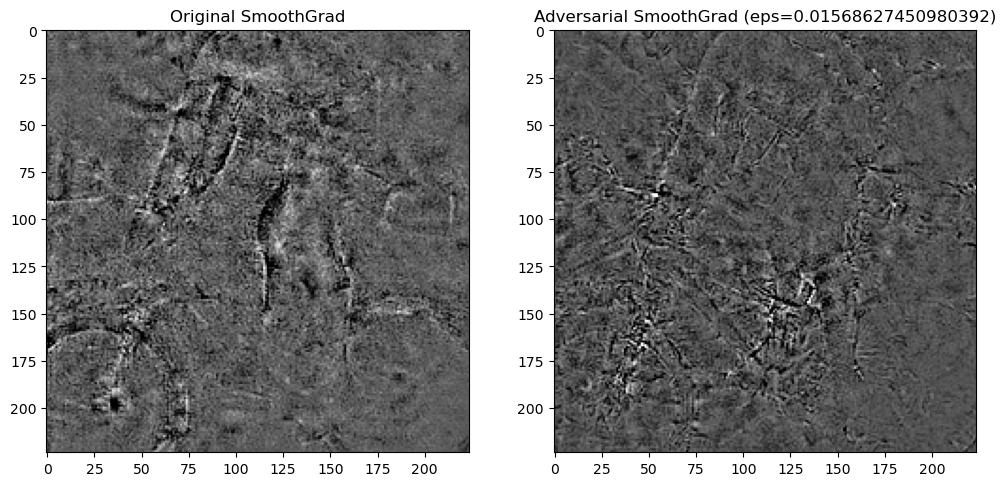

100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


Unperturbed Predicted label: n03792782 (mountain_bike)
Perturbed Predicted label: n03792782 (mountain_bike)


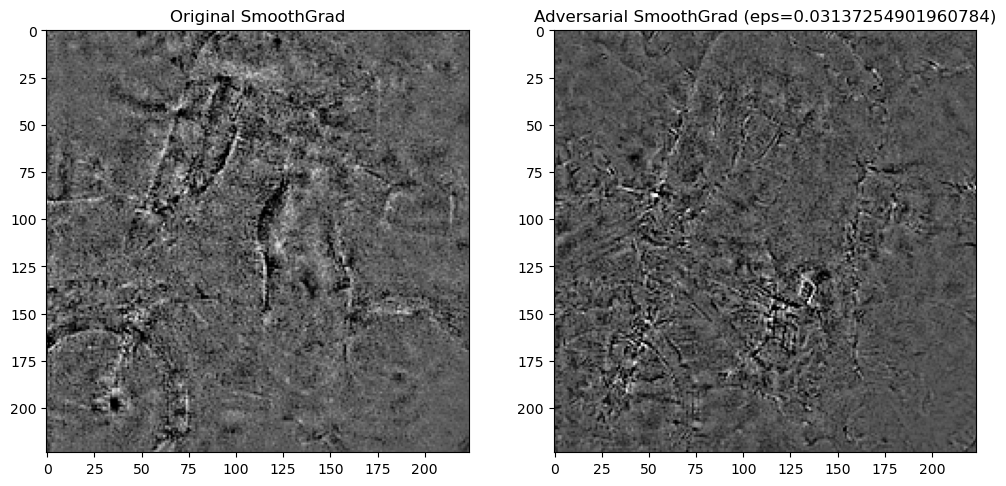

100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


Unperturbed Predicted label: n03250847 (drumstick)
Perturbed Predicted label: n03250847 (drumstick)


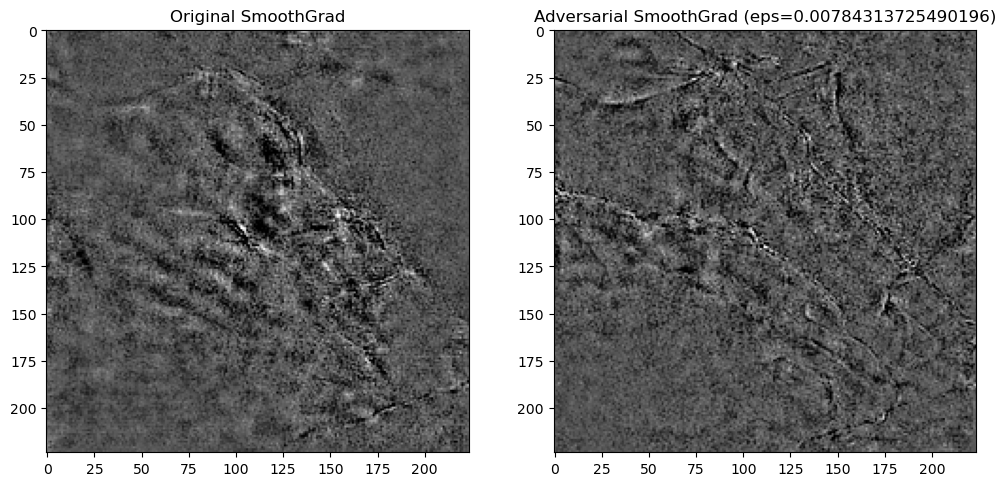

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Unperturbed Predicted label: n03250847 (drumstick)
Perturbed Predicted label: n03250847 (drumstick)


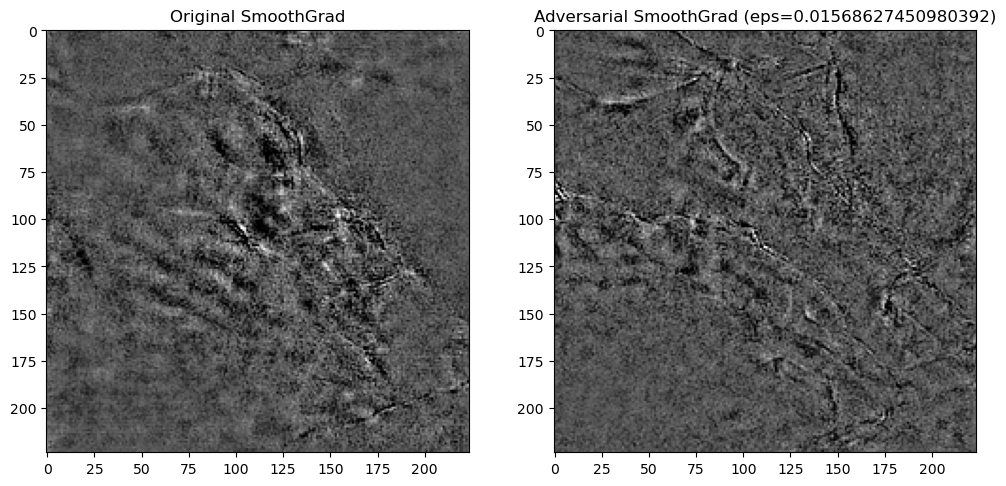

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


Unperturbed Predicted label: n03250847 (drumstick)
Perturbed Predicted label: n03250847 (drumstick)


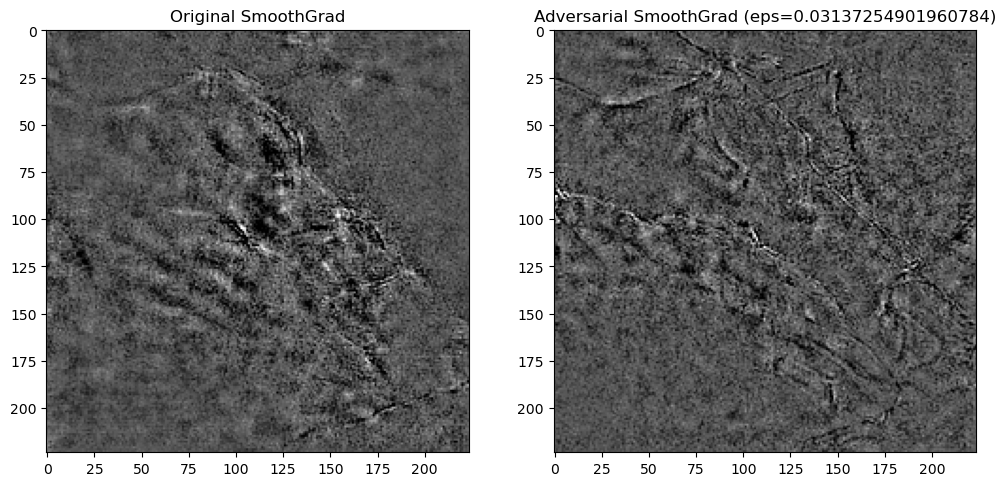

100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Unperturbed Predicted label: n04118776 (rule)
Perturbed Predicted label: n04118776 (rule)


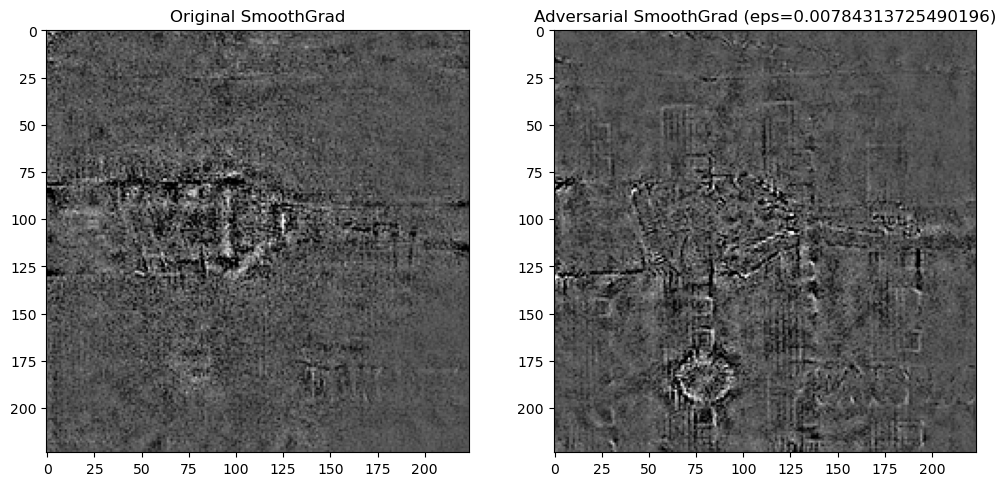

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Unperturbed Predicted label: n04118776 (rule)
Perturbed Predicted label: n04118776 (rule)


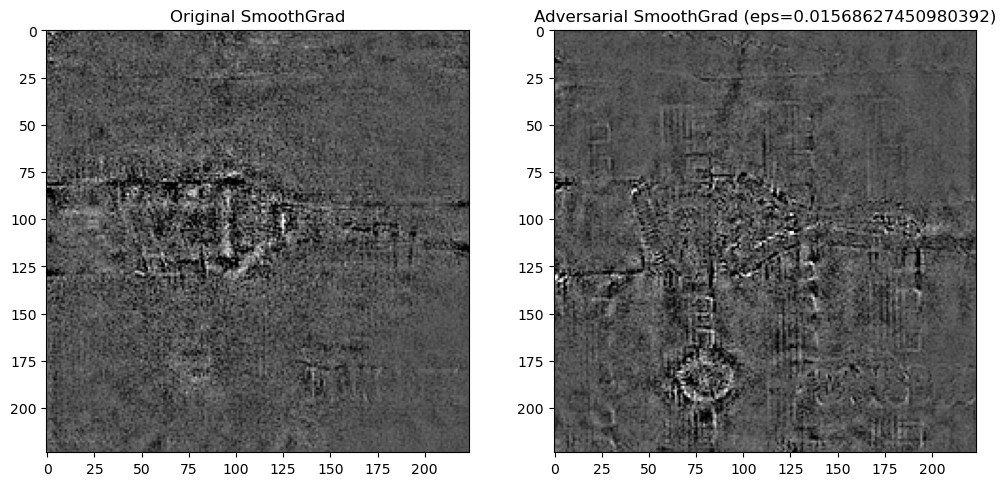

100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Unperturbed Predicted label: n04118776 (rule)
Perturbed Predicted label: n04118776 (rule)


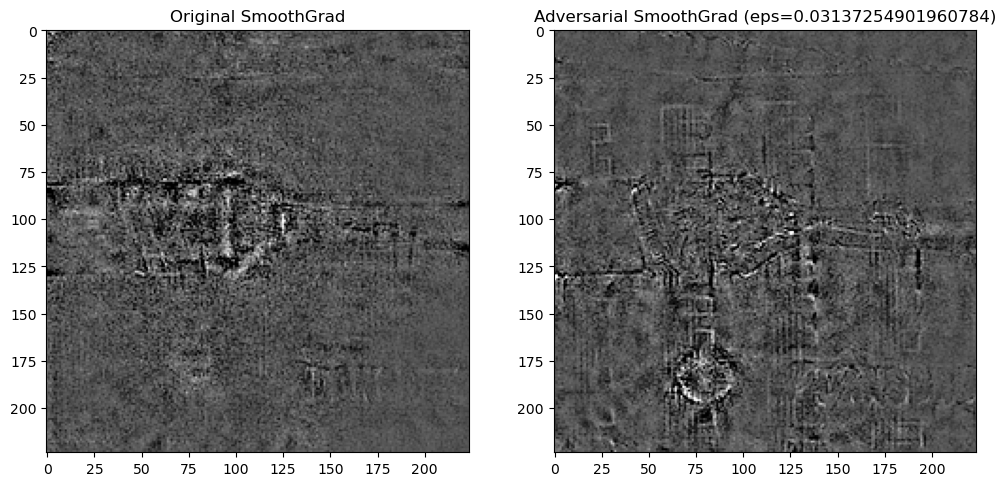

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Unperturbed Predicted label: n01806143 (peacock)
Perturbed Predicted label: n01806143 (peacock)


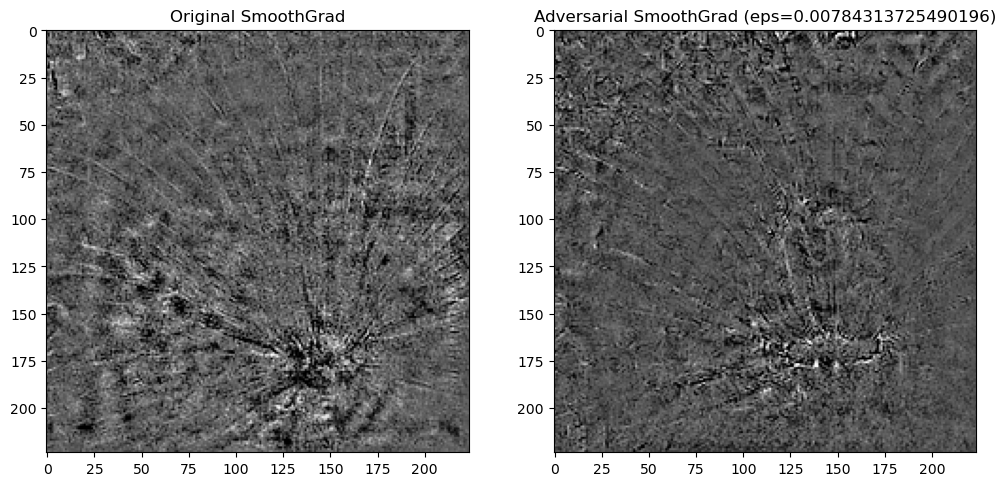

100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Unperturbed Predicted label: n01806143 (peacock)
Perturbed Predicted label: n01806143 (peacock)


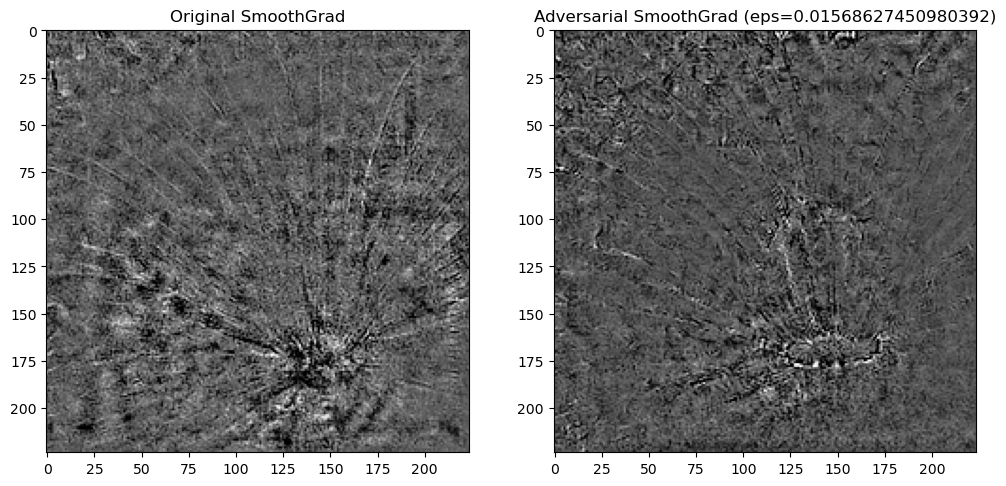

100%|██████████| 50/50 [00:17<00:00,  2.94it/s]


Unperturbed Predicted label: n01806143 (peacock)
Perturbed Predicted label: n01806143 (peacock)


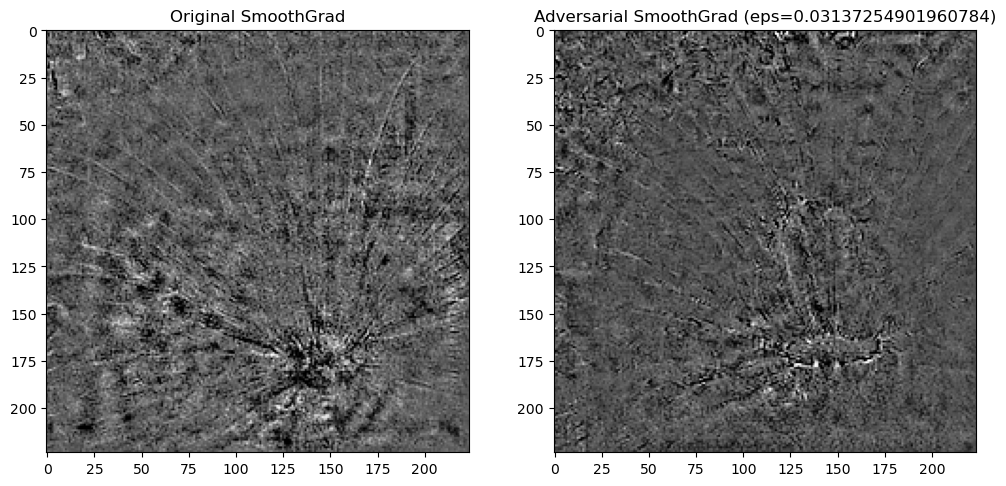

100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


Unperturbed Predicted label: n03938244 (pillow)
Perturbed Predicted label: n03938244 (pillow)


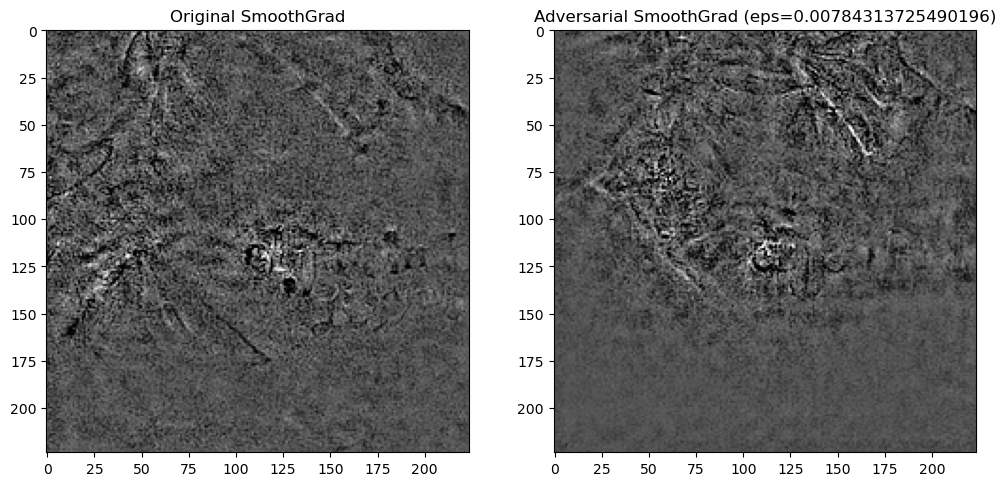

100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


Unperturbed Predicted label: n03938244 (pillow)
Perturbed Predicted label: n03938244 (pillow)


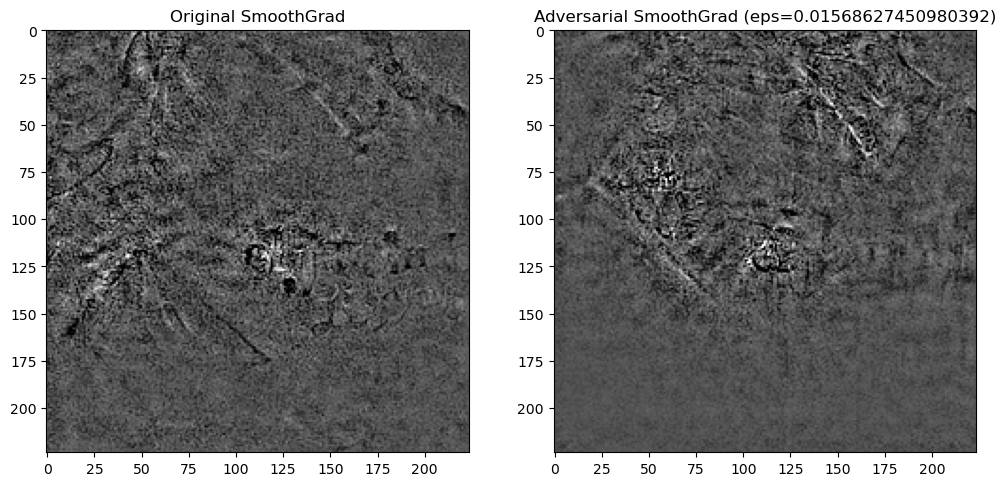

100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


Unperturbed Predicted label: n03938244 (pillow)
Perturbed Predicted label: n03938244 (pillow)


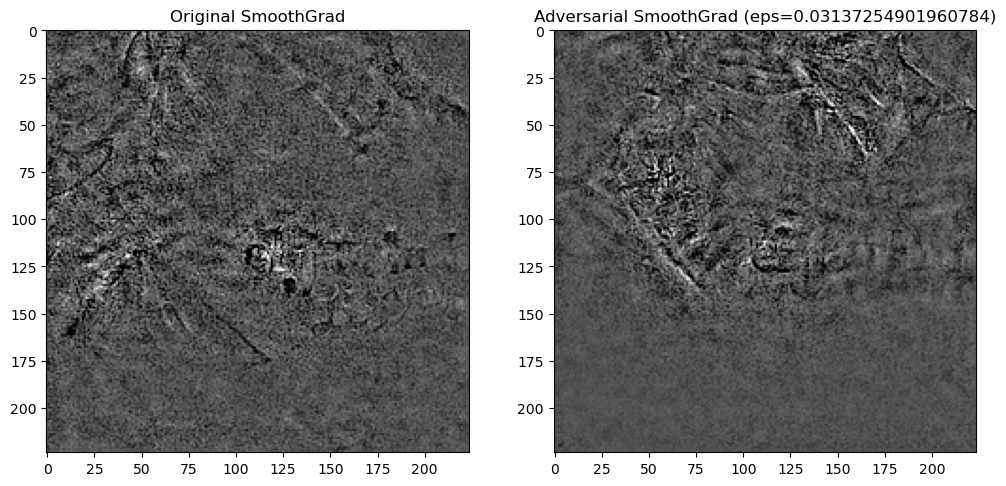

In [70]:
epsilons = [2/255, 4/255, 8/255]
n_steps = 5
smoothgrad_sigma = 0.25
smoothgrad_samples = 50

for img_path, target_class in zip(image_paths, target_classes):
    # Load and preprocess image
    input_image = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Generate original SmoothGrad explanations
    noise_img, original_explanations = generate_smoothgrad(input_batch, target_class, model, smoothgrad_sigma, smoothgrad_samples)

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    
    for epsilon in epsilons:
        adv_image = pgd_attack(
            input_batch, target_class, model, epsilon, n_steps, smoothgrad_sigma, smoothgrad_samples, original_explanations)

        with torch.no_grad():
            output = model(input_batch)

        _, adv_predicted_idx = torch.max(output, 1)
        adv_predicted_idx = adv_predicted_idx.item()
        adv_predicted_synset = idx2synset[adv_predicted_idx]
        adv_predicted_label = idx2label[adv_predicted_idx]

        # Generate SmoothGrad explanations for adversarial image
        adv_noise_img, adv_explanations = generate_smoothgrad(adv_image, target_class, model, smoothgrad_sigma, smoothgrad_samples)

        # Visualize and compare
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(noise_img, cmap='Greys')
        axes[0].set_title('Original SmoothGrad')
        axes[1].imshow(adv_noise_img, cmap='Greys')
        axes[1].set_title(f'Adversarial SmoothGrad (eps={epsilon})')
        print(f"Unperturbed Predicted label: {predicted_synset} ({predicted_label})")
        print(f"Perturbed Predicted label: {adv_predicted_synset} ({adv_predicted_label})")
        plt.savefig(f"./q2_figs/{predicted_label}_adv_{epsilon:.4f}.png")
        plt.show()
